In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.special as sps

In [2]:
def z(J):
    return np.exp(-2*J)

def mag(J):
    enum = (1+z(J)**2)**0.25 * (1-6*z(J)**2 + z(J)**4)**0.125
    den = (1-z(J)**2)**0.5
    return enum/den

def kappa(J):
    return 2 * np.sinh(2 * J) / (np.cosh(2 * J)**2)

def kappa_prime(J):
    return 2 * np.tanh(2 * J)**2 - 1

def ising_energy(J):
    k = kappa(J)
    kp = kappa_prime(J)
    return -J*coth(2 * J) * (1 + (2 / np.pi) * kp * sps.ellipk(k))

def coth(x):
    return np.cosh(x) / np.sinh(x)


def ch(j):
    kp = kappa_prime(j)
    k = kappa(j)
    a = 2/np.pi * (j * coth(2*j))**2
    bracket = 2*sps.ellipk(k) - 2*sps.ellipe(k)-(1-kp)*(np.pi/2 + kp*sps.ellipk(k))
    return a*bracket

/tmp/ipykernel_519567/2143202732.py:28: RuntimeWarning: invalid value encountered in subtract
  bracket = 2*sps.ellipk(k) - 2*sps.ellipe(k)-(1-kp)*(np.pi/2 + kp*sps.ellipk(k))


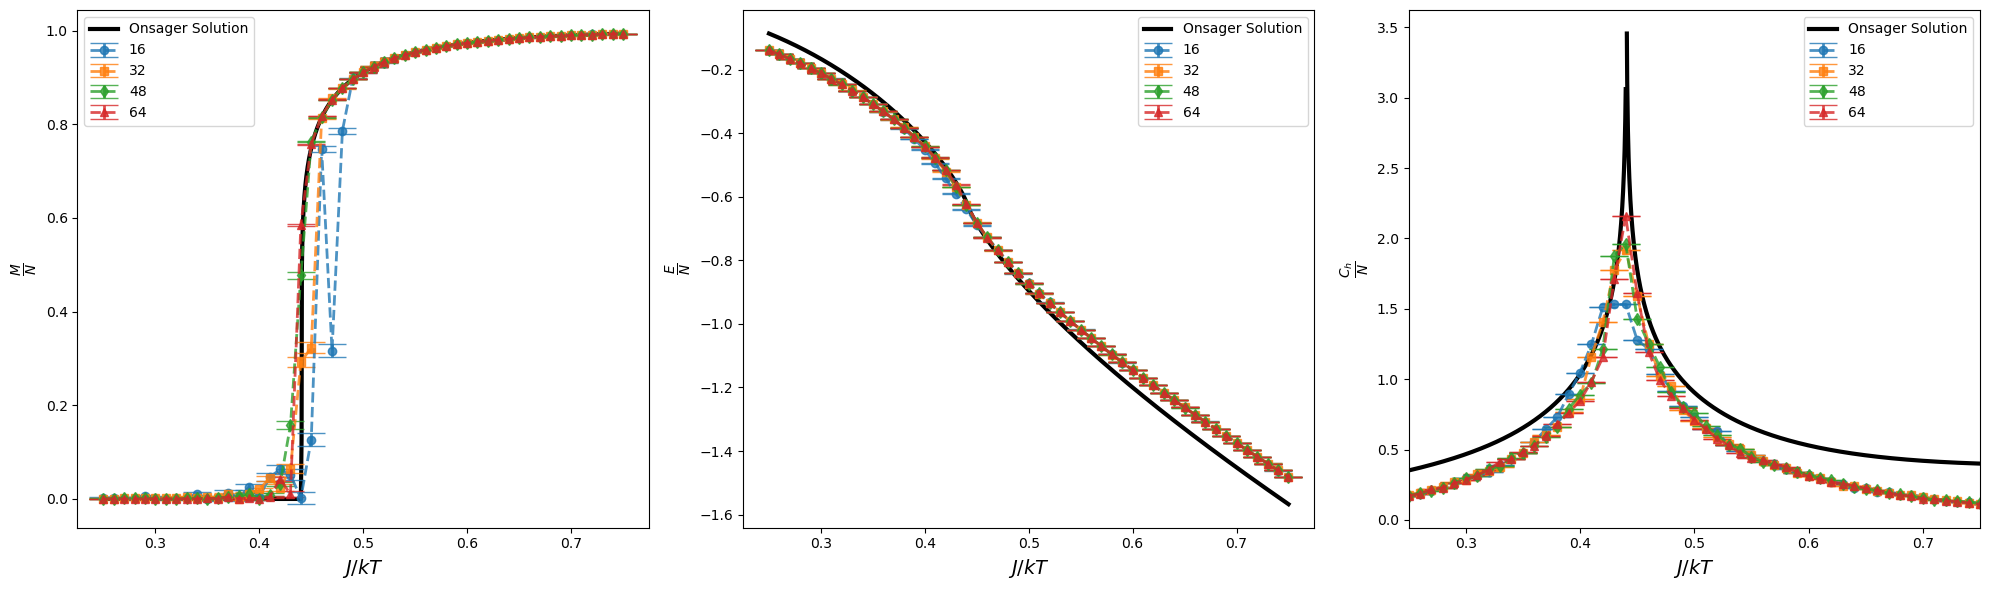

In [3]:
j_lower = np.linspace(0.25,0.44,1000)
j_upper = np.linspace(0.4406868,0.75,1000)

fig, (ax1, ax2, ax3) = plt.subplots(1,3, sharex=False, figsize=(20,6))

j = np.concatenate((j_lower, j_upper))
magnet = np.concatenate((np.zeros(len(j_lower)), mag(j_upper)))
ax1.plot(j, magnet, lw=3, color='k', label='Onsager Solution')
ax2.plot(j, ising_energy(j), lw=3, color='k', label='Onsager Solution')
ax3.plot(j, ch(j),lw=3, color='k', label='Onsager Solution')

markers = ['o', 's', 'd', '^']

for i, k in enumerate([16, 32, 48, 64]):
    # df = pd.read_csv(f'/home/moritz/Projects/chm560/analyzed/{k}x{k}.csv')
    df = pd.read_csv(f'/home/moritz/Projects/chm560/jsweep/{k}x{k}_0.0.csv')
    ax1.errorbar(df['J'], np.abs(df['M']/k**2), yerr=df['dM']/k**2,label=k, linestyle='--', marker=markers[i], alpha=.8, lw=2, capsize=10)
    ax2.errorbar(df['J'], df['E']/k**2, yerr=df['dE']/k**2,label=k, linestyle='--', marker=markers[i], alpha=.8, lw=2, capsize=10)
    ax3.errorbar(df['J'], np.abs(df['X']/k**2), yerr=df['dX']/k**2,label=k, linestyle='--', marker=markers[i], alpha=.8, lw=2, capsize=10)

plt.xlim(0.25, 0.75)
ax1.set_xlabel(r'$J / kT$', fontsize=14)
ax2.set_xlabel(r'$J / kT$', fontsize=14)
ax3.set_xlabel(r'$J / kT$', fontsize=14)

ax1.set_ylabel(r'$\frac{M}{N}$', fontsize=14)
ax2.set_ylabel(r'$\frac{E}{N}$', fontsize=14)
ax3.set_ylabel(r'$\frac{C_h}{N}$', fontsize=14)

ax1.legend()
ax2.legend()
ax3.legend()

fig.tight_layout()
fig.savefig('figures/jsweep.png', dpi=300)

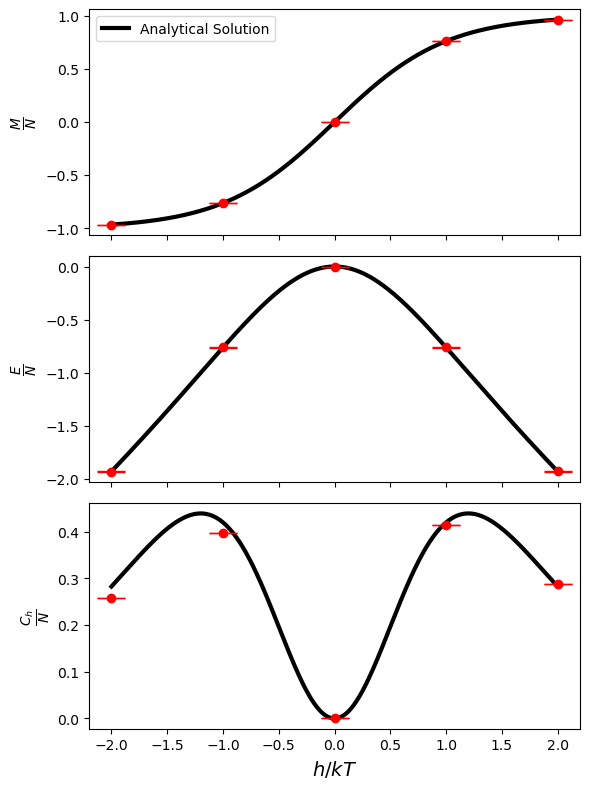

In [4]:
fig, (ax1, ax2, ax3) = plt.subplots(3,1, sharex=True, figsize=(6,8))

hcont = np.linspace(-2,2,1000)
mag = np.tanh(hcont)
ax1.plot(hcont, mag, lw=3, color='k', label='Analytical Solution')

ene = -hcont*np.tanh(hcont)
ax2.plot(hcont, ene, lw=3, color='k', label='Analytical Solution')

ch = hcont**2 *(1-np.tanh(hcont)**2)
ax3.plot(hcont, ch, lw=3, color='k', label='Analytical Solution')

for i, k in enumerate([-2.0, -1.0, 0.0, 1.0, 2.0]):
    df = pd.read_csv(f'/home/moritz/Projects/chm560/independent_spins/64x64_{k}.csv')
    ax1.errorbar(df['h'], df['M']/64**2, yerr=df['dM']/64**2, linestyle='--', marker='o', alpha=1., lw=2, capsize=10, color='red')
    ax2.errorbar(df['h'], df['E']/64**2, yerr=df['dE']/64**2, linestyle='--', marker='o', alpha=1., lw=2, capsize=10, color='red')
    ax3.errorbar(df['h'], df['X']/64**2, yerr=df['dX'], linestyle='--', marker='o', alpha=1., lw=2, capsize=10, color='red')



ax3.set_xlabel(r'$h / kT$', fontsize=14)
ax1.set_ylabel(r'$\frac{M}{N}$', fontsize=14)
ax2.set_ylabel(r'$\frac{E}{N}$', fontsize=14)
ax3.set_ylabel(r'$\frac{C_h}{N}$', fontsize=14)

ax1.legend()
fig.tight_layout()
fig.savefig('figures/j0.png', dpi=300)

(100.0, 1.0)

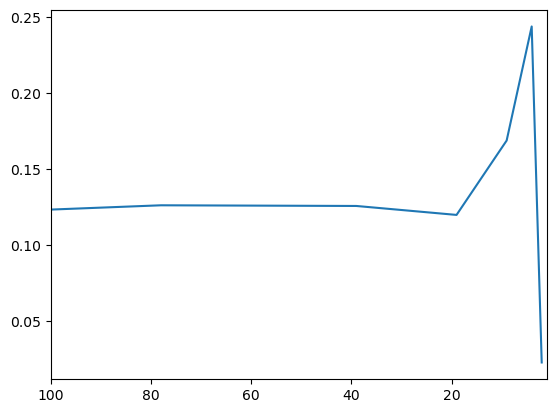

In [7]:
def block_avg(data):
    current_data = np.array(data)
    errors = []
    block_counts = []
    
    while len(current_data) > 1:
        n_blocks = len(current_data)
        block_counts.append(n_blocks)
        se = np.std(current_data, ddof=1) / np.sqrt(n_blocks-1)
        errors.append(se)
        
        if n_blocks % 2 == 1:
            current_data = current_data[:-1]
        
        current_data = 0.5 * (current_data[0::2] + current_data[1::2])
    
    error_estimate = np.average(errors[0:2])
    
    return block_counts, errors, error_estimate

df = pd.read_csv('/home/moritz/Projects/chm560/output_64x64/out_64x64_h_0.0_J_0.75.txt')
data = df['M']
block_counts, errors, error_estimate = block_avg(data)
plt.plot(block_counts, errors)
plt.xlim(100,1)